In [1]:
import os
import sys

import folium
import pandas as pd
import unidecode

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.db_functions import create_sql_alchemy_db_engine
from src.helpers import remove_accents
from src.plot_helpers import set_matplotlib_defaults

In [2]:
set_matplotlib_defaults()

In [3]:
conn = create_sql_alchemy_db_engine()

In [4]:
orders = pd.read_sql("SELECT * FROM orders", conn)
customers = (
    pd.read_sql("SELECT * FROM customers", conn)
    .rename({
        'customer_zip_code_prefix': 'zip_code_prefix', 
        'customer_city': 'city',
        'customer_state': 'state'
    }, axis=1)
    .assign(city = lambda df: df.city.apply(remove_accents))
)
geoloc = (
    pd.read_sql("SELECT * FROM geolocation", conn)
    .rename({
        'geolocation_zip_code_prefix': 'zip_code_prefix', 
        'geolocation_city': 'city',
        'geolocation_state': 'state',
        'geolocation_lat': 'lat',
        'geolocation_lng': 'lon'
    }, axis=1)
    .assign(city = lambda df: df.city.apply(remove_accents))
)

How many zip codes are in multiple cities/states?

In [5]:
(
    geoloc
    .groupby('zip_code_prefix')
    [['city', 'state']]
    .nunique()
    .query('state > 1 or city > 1')
).shape[0]

556

In [6]:
# Take the average lat-lon by zipcode, city and state
zipcode_average_latlon = (
    geoloc
    .groupby(['zip_code_prefix', 'city', 'state'])
    [['lat', 'lon']]
    .mean()
    .reset_index()
)

In [7]:
customers_with_loc = customers.merge(zipcode_average_latlon)
customers_with_loc.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  5dca924cc99eea2dc5ba40d11ec5dd0f  2761fee7f378f0a8d7682d8a3fa07ab1   
2  661897d4968f1b59bfff74c7eb2eb4fc  d06a495406b79cb8203ea21cc0942f8c   
3  702b62324327ccba20f1be3465426437  8b3d988f330c1d1c3332ccd440c147b7   
4  bdf997bae7ca819b0415f5174d6b4302  866755e25db620f8d7e81b351a15bb2f   

   zip_code_prefix    city state        lat        lon  
0            14409  franca    SP -20.498489 -47.396929  
1            14409  franca    SP -20.498489 -47.396929  
2            14409  franca    SP -20.498489 -47.396929  
3            14409  franca    SP -20.498489 -47.396929  
4            14409  franca    SP -20.498489 -47.396929

In [8]:
customers_with_loc

customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      5dca924cc99eea2dc5ba40d11ec5dd0f  2761fee7f378f0a8d7682d8a3fa07ab1   
2      661897d4968f1b59bfff74c7eb2eb4fc  d06a495406b79cb8203ea21cc0942f8c   
3      702b62324327ccba20f1be3465426437  8b3d988f330c1d1c3332ccd440c147b7   
4      bdf997bae7ca819b0415f5174d6b4302  866755e25db620f8d7e81b351a15bb2f   
...                                 ...                               ...   
99134  0b7a30ba373aeb55cf28add5b5477956  8c8173e547e020f411aa55b2fceed861   
99135  ff6b440b2465bfaef05c675efb48cd15  e38a27b979a552e019e297ecc22dc67b   
99136  3f7029d9b98a47370cd5f3a97adcbccd  5894d202cc869b4ec460fce3c6ed8cb5   
99137  d9110683c7a282144e9fc97660026a28  5cbfdb85ec130898108b32c50d619c39   
99138  6fb4f2354f36e554ac80141e9128f528  3cc6f2e1b9199837fabb35ff4bf24884   

       zip_code_prefix                  city state        lat        lon  
0                14409                franca    SP -20.498489 -47.396929  
1                14409                franca    SP -20.498489 -47.396929  
2                14409                franca    SP -20.498489 -47.396929  
3                14409                franca    SP -20.498489 -47.396929  
4                14409                franca    SP -20.498489 -47.396929  
...                ...                   ...   ...        ...        ...  
99134            87145              paicandu    PR -23.501992 -52.150755  
99135            98860     eugenio de castro    RS -28.527590 -54.145960  
99136             5538             sao paulo    SP -23.588483 -46.737908  
99137            74980  aparecida de goiania    GO -16.822735 -49.248175  
99138            99043           passo fundo    RS -28.226596 -52.467505  

[99139 rows x 7 columns]

<AxesSubplot:>

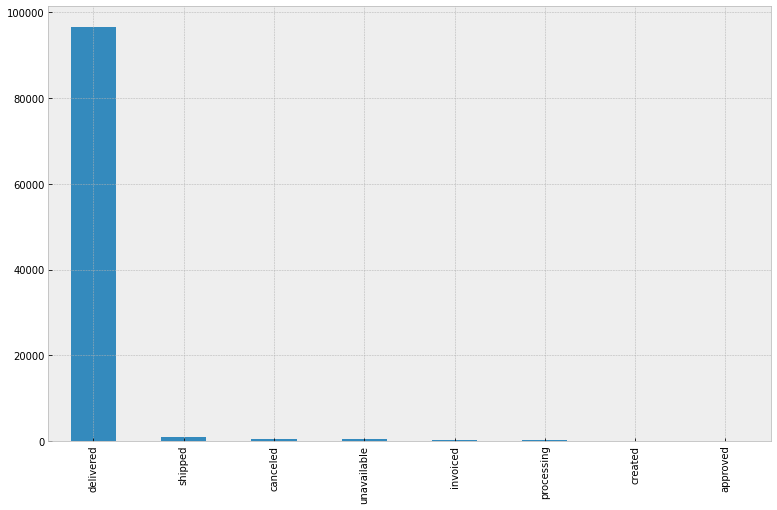

In [9]:
orders.order_status.value_counts().plot.bar()

In [10]:
orders

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp   order_approved_at  \
0        delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...            ...                      ...                 ...   
99436    delivered      2017-03-09 09:54:05 2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
0                        2017-10-18  
1                        2018-08-13  
2                        2018-09-04  
3                        2017-12-15  
4                        2018-02-26  
...                             ...  
99436                    2017-03-28  
99437                    2018-03-02  
99438                    2017-09-27  
99439                    2018-02-15  
99440                    2018-04-03  

[99441 rows x 8 columns]

In [11]:
orders_with_customer_info = orders.merge(customers_with_loc)
orders_with_customer_info

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99134  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99135  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99136  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99137  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99138  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp   order_approved_at  \
0        delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...            ...                      ...                 ...   
99134    delivered      2017-03-09 09:54:05 2017-03-09 09:54:05   
99135    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
99136    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
99137    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
99138    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99134          2017-03-10 11:18:03           2017-03-17 15:08:01   
99135          2018-02-07 23:22:42           2018-02-28 17:37:56   
99136          2017-08-28 20:52:26           2017-09-21 11:24:17   
99137          2018-01-12 15:35:03           2018-01-25 23:32:54   
99138          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date                customer_unique_id  \
0                        2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                        2018-08-13  af07308b275d755c9edb36a90c618231   
2                        2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                        2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                        2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   
...                             ...                               ...   
99134                    2017-03-28  6359f309b166b0196dbf7ad2ac62bb5a   
99135                    2018-03-02  da62f9e57a76d978d02ab5362c509660   
99136                    2017-09-27  737520a9aad80b3fbbdad19b66b37b30   
99137                    2018-02-15  5097a5312c8b157bb7be58ae360ef43c   
99138                    2018-04-03  60350aa974b26ff12caad89e55993bd6   

       zip_code_prefix                     city state        lat        lon  
0                 3149                sao paulo    SP -23.576983 -46.587161  
1                47813                barreiras    BA -12.177924 -44.660711  
2                75265               vianopolis    GO -16.745150 -48.514783  
3                59296  sao goncalo do amarante    RN  -5.774190 -35.271143  
4                 9195              santo andre    SP -23.676370 -46.514627  
...                ...                      ...   ...        ...        ...  
99134            12209      sao jose dos campos    SP -23.178

## Folium

Here we'll use folium to get a view of where the orders are being sent.
On top of these we can plot Brazil's 10 largest cities' lat-lons (taken from [here](https://simplemaps.com/data/br-cities)).

In [12]:
city_lat_lons = {
    'Sao Paolo': (-23.5504, -46.6339),
    'Rio De Janeiro': (-22.9083, -43.1964),
    'Belo Horizonte': (-19.9281, -43.9419),
    'Brasilia': (-15.7939, -47.8828),
    'Salvador': (-12.9708, -38.5108),
    'Fortaleza': (-3.7275, -38.5275),
    'Curitiba': (-25.4297, -49.2719),
    'Manaus': (-3.1, -60.0167),
    'Recife': (-8.0539, -34.8808),
    'Belem': (-1.4558, -48.5039)
}

In [13]:
m = folium.Map(
    location= [
        orders_with_customer_info['lat'].mean(),
        orders_with_customer_info['lon'].mean()
    ],
    tiles= 'cartodbpositron',
    zoom_start=4
)

In [14]:
for index, row in (
    orders_with_customer_info
    .sample(n=int(len(orders_with_customer_info)/10)) # Take a 10% random sample
    .iterrows() # As ~ 100,000 dots causes problems with plotting
):
    lat = row['lat']
    lon = row['lon']
    
    folium.Circle(
        radius=1,
        location=[lat, lon]
    ).add_to(m)

In [15]:
for key, (lat, lon) in city_lat_lons.items():
    folium.Circle(
        radius=100000,
        location= [lat, lon],
        tooltip=key,
        color='red',
        fill=True
    ).add_to(m)

In [16]:
m

Most major cities are on or near the coast, and the bulk of the orders follow this pattern. There are much fewer orders being made further inland, relative to nearer the coast.

In [17]:
m.save("../figures/orders_location_folium.html")

In [18]:
orders_with_customer_info.to_parquet('../data/processed/orders_with_cust_info.parquet')